# **ARIMA**

In [ ]:
!git clone https://github.com/Astralex98/MOSD_2023.git

In [ ]:
%cd MOSD_2023/Seminar_3

In [ ]:
!pwd

## Dependencies

In [ ]:
! unzip data.zip -d .

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels as sm
import statsmodels.api

from tqdm import tqdm

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### А. Downloading data

In [ ]:
dataset = pd.read_csv("./data/mauna_loa_atmospheric_c02.csv",
                      index_col=None, usecols=["date", "WMLCO2"])

In [ ]:
dataset.head()

,date,WMLCO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


When loading a time series in Pandas, you must explicitly indicate the need
converting date-time stamps from text to date-time format.

* This can also be specified when calling `pd.read_csv`

In [ ]:
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y-%m-%d")

Rename columns

In [ ]:
dataset = dataset.rename(columns={"date": "data", "WMLCO2": "concentration CO2"})

In [ ]:
dataset.head()

,data,concentration CO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


#### В. Filling missing values

In [ ]:
maginfy_slice = slice("1960", "1967")

In [ ]:
dataset_pinterp = dataset.interpolate(method='polynomial', order=2)
full_dataset = dataset_pinterp

 ### C. Preparation of test and train samples

In [ ]:
dataset_pinterp = dataset.interpolate(method='polynomial', order=2)
full_dataset = dataset_pinterp

In [ ]:
holdout = full_dataset.loc["1991-01-01":]

dataset = full_dataset.loc[:"1990-12-31"]

print(len(dataset), len(holdout))

394 132


Make sure the parts don't overlap

In [ ]:
pd.concat([
    dataset.tail(),
    holdout.head()
], axis=1)

,concentration CO2,concentration CO2
data,,
1990-08-31,352.250,NaN
1990-09-30,350.950,NaN
1990-10-31,351.400,NaN
1990-11-30,353.075,NaN
1990-12-31,354.260,NaN
1991-01-31,NaN,354.925
1991-02-28,NaN,355.950
1991-03-31,NaN,357.400
1991-04-30,NaN,358.700


Explicitly preserve the boundaries of the segments

In [ ]:
holdout_slice = slice(*holdout.index[[0, -1]])

print("Train sample from {} to {}".format(*dataset.index[[0, -1]]))

print("Test sample from {} to {}".format(holdout_slice.start, holdout_slice.stop))

Train sample from 1958-03-31 00:00:00 to 1990-12-31 00:00:00
Test sample from 1991-01-31 00:00:00 to 2001-12-31 00:00:00


Choose a column

In [ ]:
target_column = "concentration CO2"

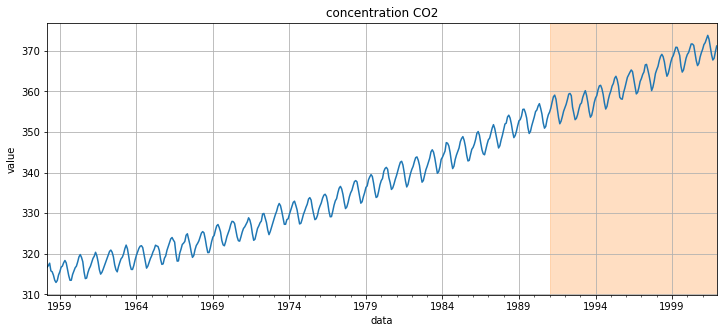

In [ ]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plote dynamic of the whole series
full_dataset[target_column].plot(ax=ax)

# darkening delayed interval
ax.axvspan(holdout_slice.start, holdout_slice.stop,
           color="C1", alpha=0.25, zorder=-99)

ax.grid(which="major", axis="both") ;


<br>

###   А. Moving characteristics

Below is a procedure for conveniently plotting diagnostic graphs.

In [ ]:
def rolling_diagnostics(series, window=500):
    rolling = series.rolling(window)

    # Create and set plots: upper and down
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Moving average", xlabel="Data", ylabel="value")
    ax_bottom = fig.add_subplot(212, title="Moving stdv",
                                sharex=ax_top, xlabel="Data", ylabel="stdv")

    # plot graphs:
    # serries and moving average


    #rolling_mean = TODO
    rolling_mean.plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # moving standard deviation
    #rolling_std = TODO
    rolling_std.plot(ax=ax_bottom)
    ax_bottom.grid(which="major", axis="both")

    fig.tight_layout()
    return fig

From the graphs of moving statistics, we can suggest that there is a trend in the dynamics of values.

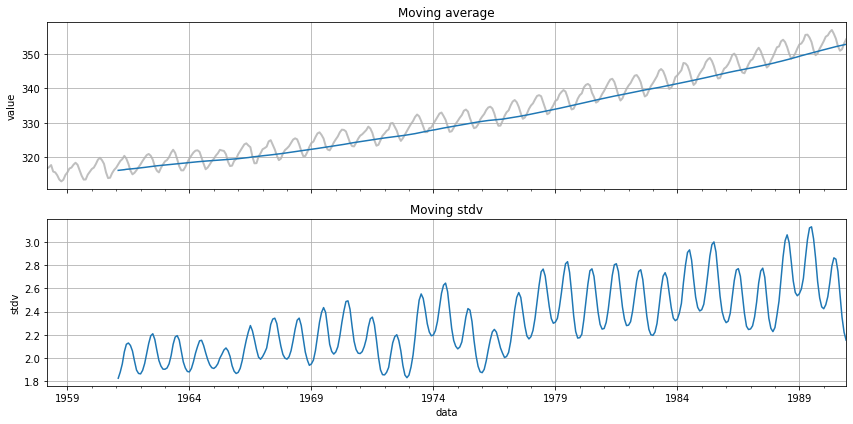

In [ ]:
rolling_diagnostics(dataset[target_column], window=36);

<br>

### Rough estimate of seasonality

You can try researching seasonality, such as monthly or weekly.

* when assessing seasonality, it is desirable that seasonal adjustments are made relative to the trend.

In [ ]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period="month"):
    # use nonparametric local linear regression to estimate the trend
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # let's group by month and calculate the average and std. deviation
    by = getattr(series.index, period, "month")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # create and plot graphs: upper and down
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Trend", xlabel="Data")
    ax_bottom = fig.add_subplot(212, title="Seasonality", xlabel=period)

    # plot graphs
    # series and trend
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # seasonality and 90% confidence interval
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig

Plots shows seasonality in dynamics

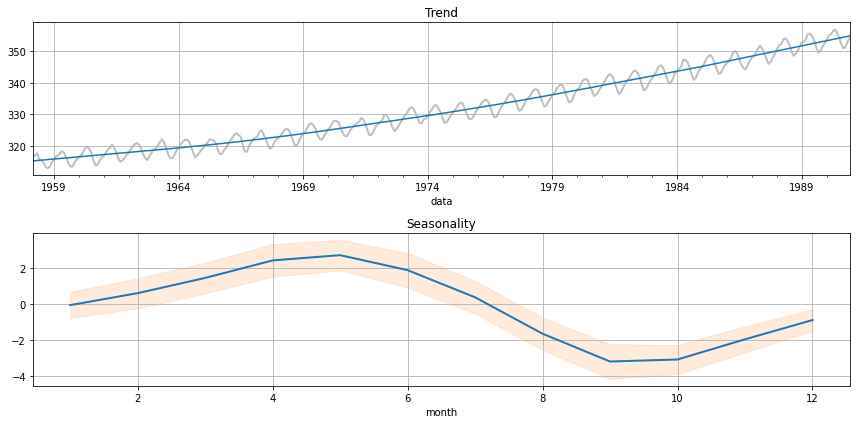

In [ ]:
monthly_seasonality_diagnostics(dataset[target_column], fraction=0.33, period="month");

<br>

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

Below is a procedure for conveniently plotting diagnostic graphs.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def correlation_diagnostics(series, lags=60):
    # create and set plots: left and right
    fig = plt.figure(figsize=(12, 3))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={"xlabel": "Lag", "ylim": (-1.1, 1.1)})

    # Plot graphs using built-in functions from statsmodels
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title="Sample Autocorrelation", marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title="Sample Partial Autocorrelation", marker=None)

    fig.tight_layout()
    return fig

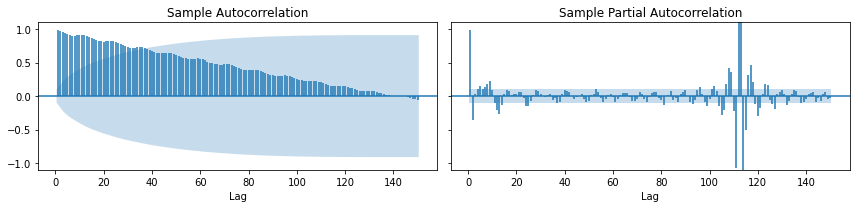

In [ ]:
correlation_diagnostics(dataset[target_column], lags=150);

All diagnostics in one procedure:

In [ ]:
def diagnostics(series, window=250, fraction=0.25, lags=150):
    # moving statistics
    rolling_diagnostics(series, window=window)
    plt.show()
    plt.close()

    # rough seasonality
    monthly_seasonality_diagnostics(series, fraction=fraction)
    plt.show()
    plt.close()

    # autocorrelation
    correlation_diagnostics(series, lags=lags)
    plt.show()
    plt.close()

    return stat_test_diagnostics(series)

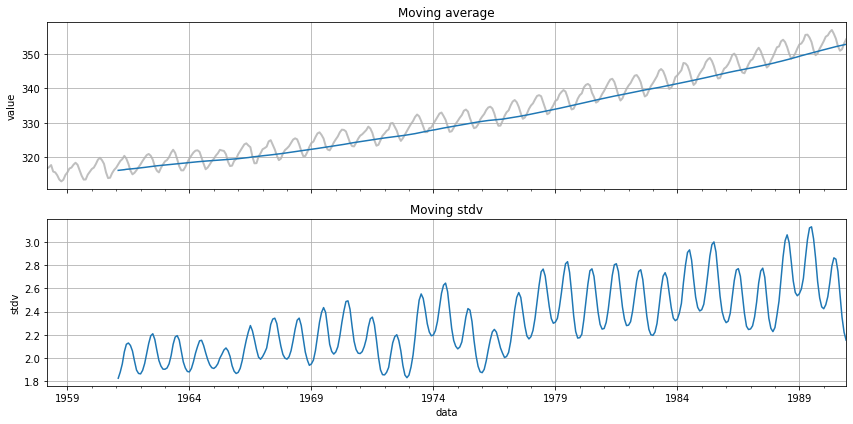

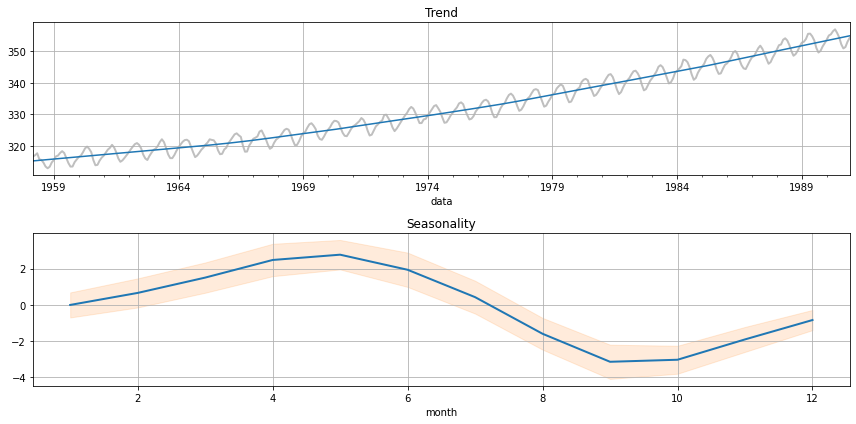

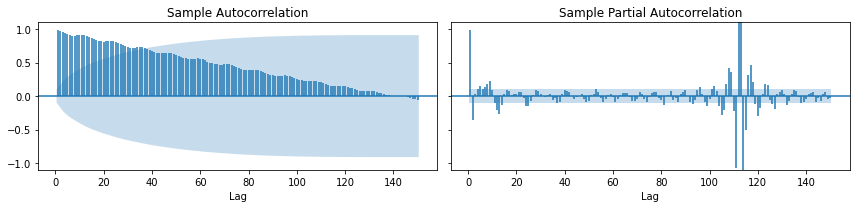

{'ADF': (-1.587175692351367, 0.7974141230613739),
 'KPSS': (2.257720311566913, 0.01)}

In [ ]:
diagnostics(dataset[target_column], window=36)

### Problem

**Without stationarity** it is very difficult to model the series

* no stable invariant patterns suitable for modeling and forecasting

### What to do?

In time series analysis, everything is exactly the same as with optimization problems.
* successfully solved problems of **convex** programming
* but all interesting practical problems are **non-convex**

If **bring** the series as close as possible to the stationary one, **taking into account the trend, seasonality and other spoiling factors**
then **we can hope for** more or less successful **modeling and solution** of applied problems.

<br>

# <span style="color:blue;">**Seminar 2**</span>

   
#### Seminar 2.
    
3. Building a time series model:
    1. Bringing data to a stationary form
    2. The Holt-Winters trend and seasonality model
    3. Validation of the time series model (evaluation metrics)
    

#### Key steps

`I`. **"Stable" time series** using
  * transformations
    - $ y \mapsto \log {y} $, $ y \mapsto \frac {y ^ q - 1} {q} $, or $ y \mapsto \sqrt {y} $;
    - offset and scaling

  * taking sequential or seasonal differences

  * highlighting and subtracting trend / seasonality

  * definition of special dates or events
    - state and religious holidays
    - moments of equipment replacement
    - facts of crossing the boundary of rocks

  * testing hypotheses about trend type and seasonality
    * **deterministic** - it is enough to evaluate it and then subtract
    * **stochastic** - it is necessary to take consecutive / seasonal differences of the series

  * etc.

<span style = "color: red;"> ** IMPORTANT ** </span> Inverse transformations must be applied to forecasts in ** reverse ** order!

`II`. **Estimating the parameters of the model**
  * Likelihood maximization, $ L ^ 2 $ minimization of the loss function or empirical risk, etc.
  
  * take into account heteroscedasticity and autocorrelation effects

`III`.  **Visualization of residues**
  * look at the dynamics of the series, at full and partial autocorrelations, moving statistics

  * check balances against model specification requirements

    - *satisfactory* lack of autocorrelation

    - *satisfactory* constant mean and variance

`IV`. **Model validation**

* model validation by a reasonable method (consistent with the scenario of its use)

* calculation of **forecasts on a deferred** sample

The time series modeling strategy is based on the ideas described in the work

* Box, George; Jenkins, Gwilym (1970). *Time Series Analysis: Forecasting and Control.* San Francisco: Holden-Day.

##### All models are wrong, but some are useful

> Since all models are wrong the scientist cannot obtain a "correct" one by excessive elaboration ... he should seek an economical description of natural phenomena.

George E. P. Box (1976), "Science and Statistics", *Journal of the American Statistical Association,* **71**, 791-799, DOI: [10.1080/01621459.1976.10480949](https://doi.org/10.1080/01621459.1976.10480949)

In practice, the time series model needs to be updated and retrained when sufficient new data is accumulated.

As with any modeling, in time series analysis, only the necessary components should be included in the model, and then strive for the simplest model (`parsimony`).

####  А. Bringing data to a stationary form

In [ ]:
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler

Our seria is positive, so we can take logs

In [ ]:
#TODO: apply other transformations to the data and try to find the best for making Time Series non-stationary

from sklearn.pipeline import Pipeline

transformer = Pipeline([
    ("Log", FunctionTransformer(func=np.log, inverse_func=np.exp),),

    ("Scaling", StandardScaler(),),
])

Transformation

In [ ]:
log_dataset = pd.DataFrame(transformer.fit_transform(dataset),
                           columns=dataset.columns,
                           index=dataset.index)

In [ ]:
log_dataset.head()

,concentration CO2
data,
1958-03-31,-1.296455
1958-04-30,-1.261055
1958-05-31,-1.208038
1958-06-30,-1.376270
1958-07-31,-1.396259


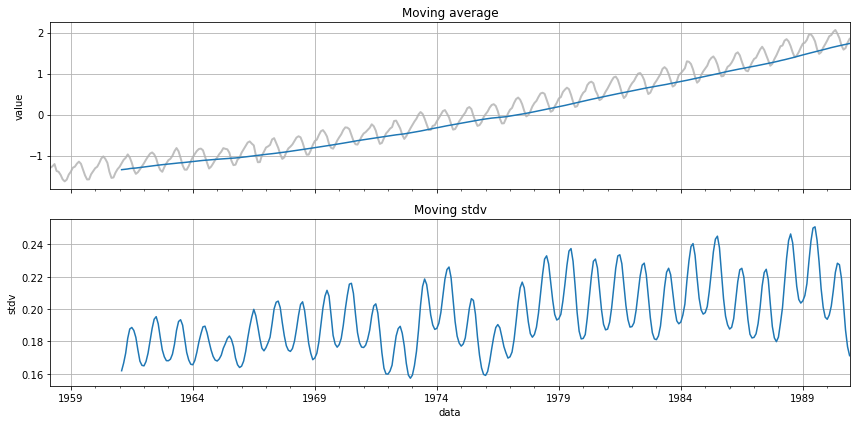

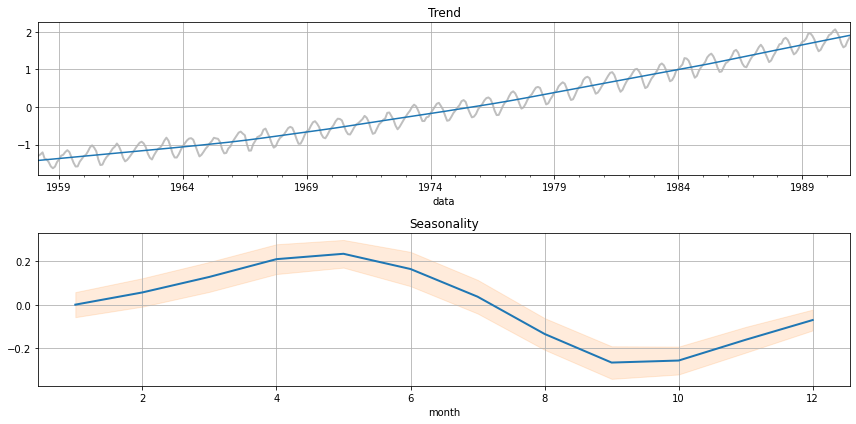

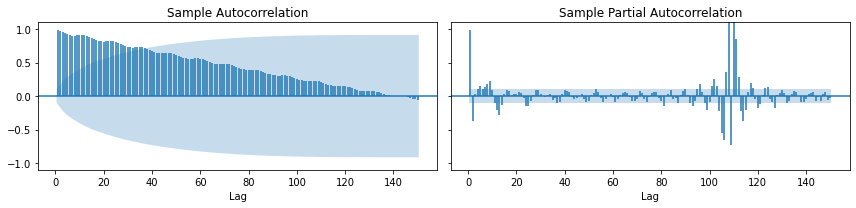

{'ADF': (-1.815360910955939, 0.6973047105178262),
 'KPSS': (2.264517786224465, 0.01)}

In [ ]:
diagnostics(log_dataset[target_column], window=36)

The transformation did not give any special changes, but usually taking logarithms makes the estimation of the model parameters more stable.

Transform train sample in advance

In [ ]:
train = transformer.fit_transform(dataset.values)

train = pd.DataFrame(train, index=dataset.index, columns=dataset.columns)

### B. The Holt-Winters trend and seasonality model

Generalized exponential smoothing with local linear trends and seasonality

* **+** simple model based on simple ideas

* **-** usually the highlighted trend is a little "lagging"

* **-** Manual deterministic seasonality period

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

The forecast of the value of $ y_ {t + h} $ for $ h $ steps forward from the time $ t $ has the form

$$
    \hat{y}_{t+h\mid t}
        = l_t + h b_t + s_{t - m + h^+_m}
        \,, \quad
    h^+_\pi
        = 1 + \bigl((h - 1) \mod m\bigr)
\,, $$

где
* $ m $ - period of the seasonal cycle, $ h^+_ m $ seasonal index

* Local *level* of series $l_t = \alpha (y_t - s_{t-m}) + (1 - \alpha) (l_{t-1} + b_{t-1})$

* Local trend slope $b_t = \beta (l_t - l_{t-1}) + (1 - \beta) b_{t-1}$

* *Periodic* effects $ s_t = \gamma (y_t - (l_{t-1} + b_{t-1})) + (1 - \gamma) s_{t-m}$

The parameters are estimated by solving the problem of minimizing *the standard deviation*
$\hat{y}_{t+1\mid t}$ from $y_{t+1}$:

* $\alpha$, $\beta$ и $\gamma$
* start effect of seasonality $s_1,\,\ldots,\,s_m$
* start level and slope coef $l_1$ и $b_1$

In [ ]:
exp_smooth = ExponentialSmoothing(train,
                                  trend="add",         # additivie trend
                                  seasonal="add",      # additive seasonality
                                  seasonal_periods=12)

exp_smooth_fitted = exp_smooth.fit(remove_bias=True)

If there is no seasonality ($ s_t = 0 $) and slope ($ b_t = 0 $), then

* for $ \alpha \approx 1 $, the forecast of $\hat {y} _ {t + h \mid t} $ of the value of $ y_ {t + h} $ is $ y_t $

* at $ \alpha \approx 0 $ the forecast corresponds to the historical average

In [ ]:
exp_smooth_fitted.params

{'smoothing_level': 0.6188543492647872,
 'smoothing_trend': 0.009128013502226489,
 'smoothing_seasonal': 0.0,
 'damping_trend': nan,
 'initial_level': 0.05655040969339549,
 'initial_trend': 0.0068396706605974985,
 'initial_seasons': array([-1.3801562 , -1.2987529 , -1.27420656, -1.3442586 , -1.47132734,
        -1.64261268, -1.77407999, -1.76483089, -1.66948583, -1.57896218,
        -1.50809837, -1.45210677]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': True}

Let's look at its residuals on the training set.

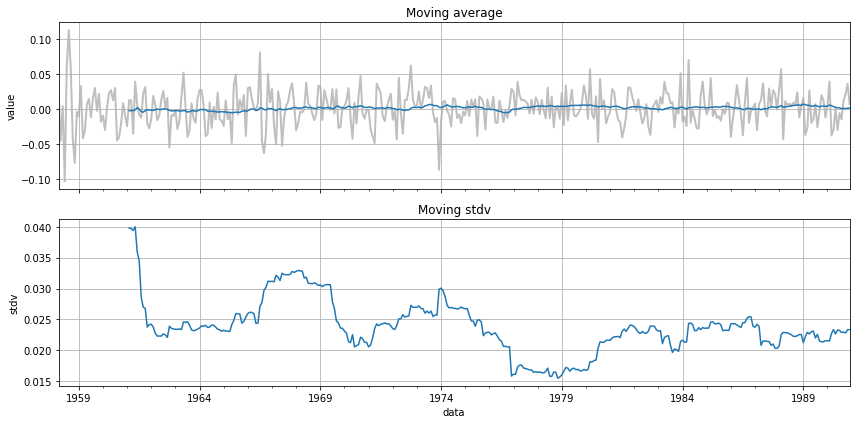

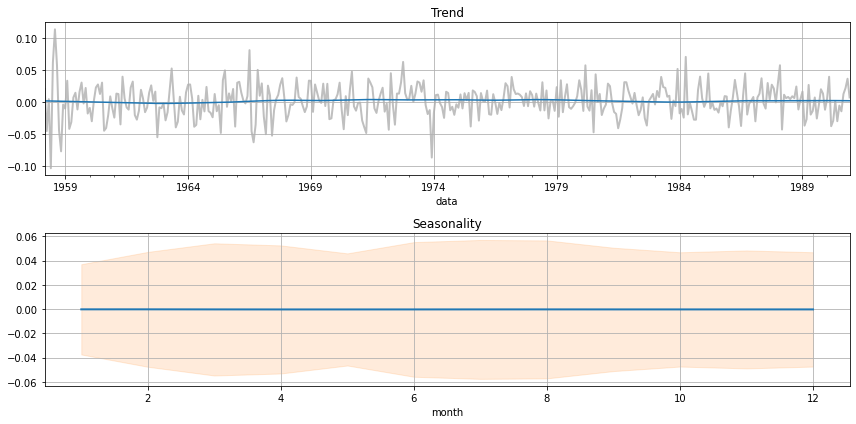

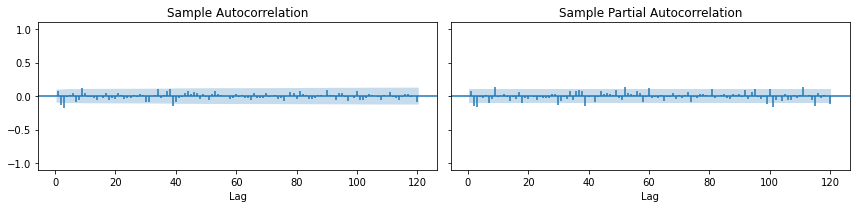

{'ADF': (-14.448714990539115, 4.740962160177742e-22),
 'KPSS': (0.2260834007017367, 0.1)}

In [ ]:
diagnostics(exp_smooth_fitted.resid, window=36, lags=120)

The quantile-quantile Q-Q plot indicates that the distribution of residues has "heavy tails", rather
all due to inconsistent dispersion.

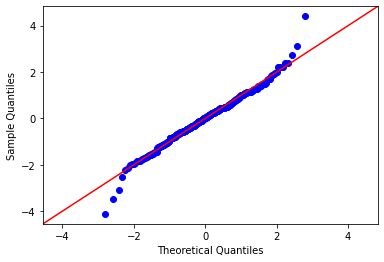

In [ ]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

qqplot(exp_smooth_fitted.resid, fit=True, line='45');

Do not forget that we applied the transformations to the series

In [ ]:
series_fitted = exp_smooth_fitted.fittedvalues.to_frame()

series_fitted = transformer.inverse_transform(series_fitted)

fitted_holt_winters = pd.Series(series_fitted.ravel(),
                                name=target_column,
                                index=dataset.index)

Let's see the fit

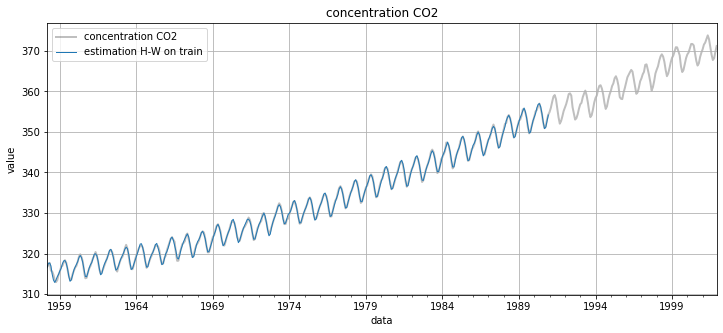

In [ ]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plot dynamic of whole series
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=.25, zorder=-10)

fitted_holt_winters.plot(ax=ax, color="C0", lw=1, alpha=1.0,
                         label="estimation H-W on train")

ax.grid(which="major", axis="both")
ax.legend() ;


Let's look at the residuals on the training set

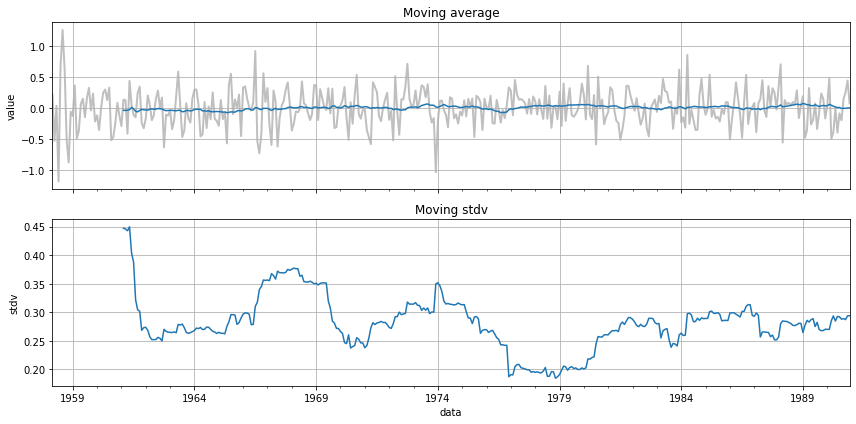

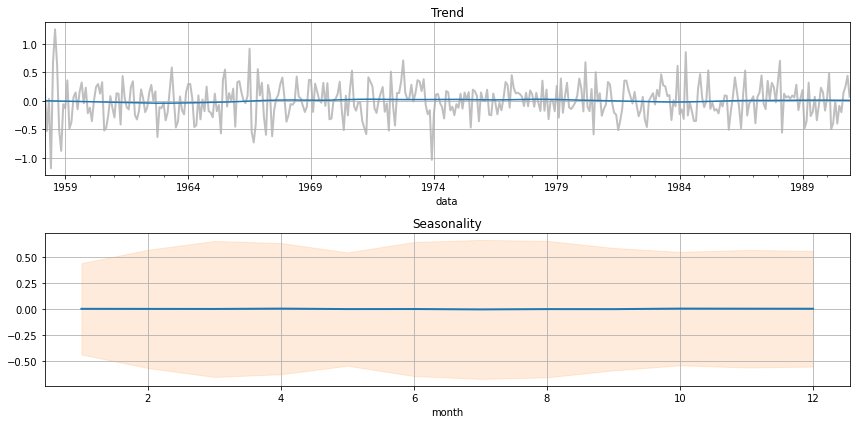

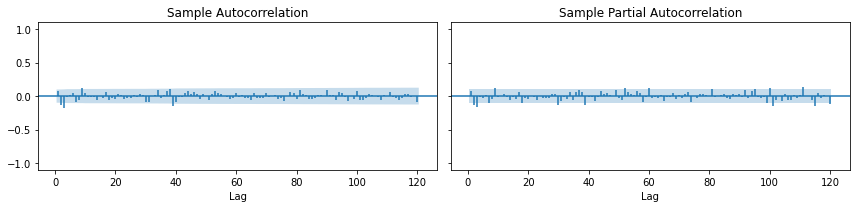

{'ADF': (-14.247310792780945, 6.753279662141638e-22),
 'KPSS': (0.21682358563970255, 0.1)}

In [ ]:
residuals = dataset[target_column] - fitted_holt_winters

diagnostics(residuals, window=36, lags=120)

Plot the quantile-quantile Q-Q for the residuals in the original scale

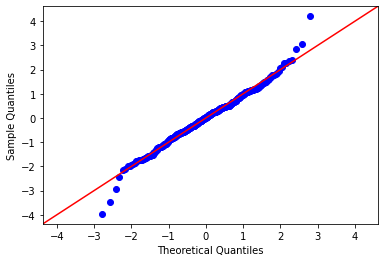

In [ ]:
qqplot(residuals, fit=True, line='45');

Judging by the sample autocorrelations, the series of residuals is very similar to the stationary
* no autocorrelations left
* no deterministic, stochastic trend

**CONCLUSION** The exponential smoothing model can be **useful** for predicting this process.

### C. Validation of the time series model (evaluation metrics)

#### Forecasting

**Purpose** - to build a trajectory of forecasts of future values on the $ h $ horizon using the available information at the time $ t $ * inclusive *.

If **exogenous** variables are involved in the time series model, then it is imperative that
* **known future trajectory** of exogenous variables $ x_ {t + h}, \, x_ {t + h-1}, \, \ ldots $

  - forecasts $ x_t $ from other models (which should not use $ y_t $)

#### Dynamic or out-of-sample

$ \hat {y} _ {s \mid t} $ forecasts for $ s = t + 1, \, ..., \, t + h $ are calculated by

* trajectories of **exogenous** variables up to the moment $ s $ *inclusive* ($ x_s, \, x_ {s-1}, \, ... $)

* prehistories of predictions $ \hat {y} _ {j \ mid t} $ for $ j = s-1, \, \ldots, \, t, \, t-1, \, \ldots $, with $ \hat {y} _ {j \mid t} = y_j $ if $ j \leq t $ - actual historical value is used.

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \color{blue}{\hat{y}_{t+1\mid t}}
  , \color{gray}{\hat{y}_{t+2\mid t}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1\mid t}}
  , \color{gray}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1\mid t}
  , \color{blue}{\hat{y}_{t+2\mid t}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1\mid t}}
  , \color{gray}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
        , \hat{y}_{t+2\mid t}
        , \ldots
        , \hat{y}_{t+h-1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1\mid t}
  , \hat{y}_{t+2\mid t}
  , \ldots
  , \hat{y}_{t+h-1\mid t}
  , \color{blue}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

#### Static or intra-sample

Consecutive one-step dynamic forecasts are calculated
$ \tilde {y} _s = \hat {y} _ {s \mid s-1} $ for $ s = t + 1, \, \ldots, \, t + h $

- must be available **trajectory of values** endogenous variables $ y_t $ (*actual*);

Healthy
- to validate a pretrained model on a known dataset

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
      }}^{\color{blue}{\hat{y}_{t+1\mid t}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , \color{red}{y_{t+1}}
  , \color{gray}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
      }}^{\color{blue}{\hat{y}_{t+2\mid t+1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , \color{red}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
        , y_{t+2}
        , \ldots
        , y_{t+h-1}
      }}^{\color{blue}{\hat{y}_{t+h\mid t+h-1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , y_{t+2}
  , \ldots
  , y_{t+h-1}
  , \color{red}{y_{t+h}}
  , \ldots
\end{aligned}

We will evaluate the forecast accuracy using these metrics

$$
    MSE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2
\,. $$

In [ ]:
from sklearn.metrics import mean_squared_error

$$
    RMSE(y, \hat{y}) = \sqrt{MSE(y, \hat{y})}
\,. $$

In [ ]:
def root_mean_squared_error(*args, **kwargs):
    return np.sqrt(mean_squared_error(*args, **kwargs))

$$
    MAE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m \bigl\lvert y_i - \hat{y}_i \bigr\rvert
\,. $$

In [ ]:
from sklearn.metrics import mean_absolute_error

$$
    \text{Median-AE}(y, \hat{y})
        = \text{median}\bigl\{
            \lvert y_1 - \hat{y}_1\rvert
            ,\, \ldots ,\,
            \lvert y_m - \hat{y}_m\rvert \bigr\}
\,. $$

In [ ]:
from sklearn.metrics import median_absolute_error

$$
    MAPE(y, \hat{y})
        = \frac1{m} \sum_{i=1}^m
            \frac{\lvert y_i - \hat{y}_i \rvert}{\lvert y_i \rvert}
\,.$$

In [ ]:
def mean_absolute_percent_error(y_true, y_pred):
    pct_error = abs(y_true - y_pred) / abs(y_true)
    return pct_error.mean(axis=0) * 100

$$
    R^2(y, \hat{y})
        = 1- \frac{\sum_{i=1}^m (y_i - \hat{y}_i)^2}{\sum_{i=1}^m (y_i - \bar{y})^2}
\,. $$

In [ ]:
from sklearn.metrics import r2_score

$$
    \text{Explained Variance}(y, \hat{y})
        = 1 - \frac{\mathop{var}(y - \hat{y})}{\mathop{var}(y)}
\,. $$

In [ ]:
from sklearn.metrics import explained_variance_score

List of all metrics

In [ ]:
scorers = [
    ("mse", mean_squared_error),
]

# TODO: use more metrics!
#scorers = [
#    ("expl-var", TODO),
#    ("mse", TODO),
#    ("rmse", TODO),
#    ("mae", TODO),
#    ("median-ae", TODO),
#    ("r2", TODO),
#    ("mape", TODO)
#]

Let's look at the **dynamic** forecast for $ 240 $ months ahead

In [ ]:
# Obtaining forecast for $ 240 $ months
exp_forecast = exp_smooth_fitted.forecast(steps=240).to_frame()

exp_forecast = pd.DataFrame(transformer.inverse_transform(exp_forecast),
                            columns=exp_forecast.columns,
                            index=exp_forecast.index)

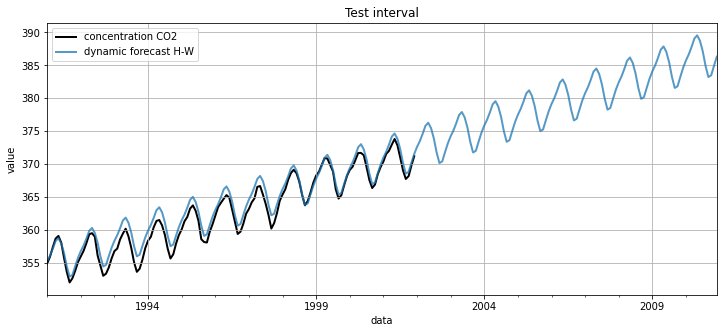

In [ ]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title="Test interval")

# plot dynamic
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

exp_forecast[0].plot(ax=ax, color="C0", lw=2, alpha=0.75, label="dynamic forecast H-W")

ax.grid(which="major", axis="both")
ax.legend()

Calculate metrics

In [ ]:
holdout_exp_smooth_score_values = pd.Series({
    name: metric(holdout[target_column],
                 exp_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [ ]:
holdout_exp_smooth_score_values

mse    1.447563
dtype: float64

Compare with the simplest baseline - **forecast with the last known value**

In [ ]:
last_known_forecast = full_dataset.shift(1).loc[holdout_slice]

holdout_last_known_score_values = pd.Series({
    name: metric(holdout[target_column], last_known_forecast[target_column])
    for name, metric in scorers
})

In [ ]:
holdout_last_known_score_values

mse    1.626034
dtype: float64

### Validation of the model of time series

Moving validation forward in time:

1 . sequential **leave-one-out**:

  - we train the model, predict one future observation, move for one observation forward

2. sequential $ k $ - **fold**:

  - we split the sample into $ k $ consecutive blocks **without** mixing

  - we train the model, predict for the entire subsequent block, move for one block forward

Len of train sample during validation

- in training sample there is fixed number $w$ of observations $(x_s, y_s)_{s=t+1-w}^t$ -- *(rolling window)*

- in training sample there is whole backstory of observations  $(x_s, y_s)_{s \leq t}$ -- *(rolling prediction origin)*

#### Onestep with train sample of fixed len

<img src="./figures/in-sample.png" title="одношаговая валидация с фиксированным окном"
alt="https://blog.cadre.com/how-cadre-uses-machine-learning-to-target-real-estate-markets-3c03ca1dac26">

#### $k$-fold with growing training sample

`Scikit-learn` has a built-in procedure for $ k $ -fold time series validation with **growing training sample**

<img src="./figures/ts-k-fold.png" title="k-fold кроссвалидация временных рядов"
alt="https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection">

Materials: https://habr.com/ru/company/ods/blog/327242/

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=20, max_train_size=None)

Let's use handy functions from  `scikit` for indexing `pandas` matrix and coping of models

In [ ]:
from sklearn.utils import _safe_indexing as safe_indexing

from sklearn.base import clone

Let's do a validation of model

In [ ]:
raw_forecast = np.full_like(dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split on train and test
    cv_train = safe_indexing(dataset, train_ix)

    # 1. "forward transformation" of series
    cv_transformer = clone(transformer).fit(cv_train)
    cv_train = pd.DataFrame(cv_transformer.transform(cv_train),
                            index=cv_train.index, columns=cv_train.columns)

    # 2. model estimation
    cv_model = ExponentialSmoothing(cv_train[target_column], trend="add",
                                    seasonal="add", seasonal_periods=12)
    cv_model = cv_model.fit()

    # 3. building a forecast
    cv_test = safe_indexing(dataset, test_ix)
    cv_forecast = cv_model.forecast(len(cv_test)).to_frame()

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_forecast)

tscv_exp_smooth_forecast = pd.DataFrame(raw_forecast, index=dataset.index, columns=dataset.columns)

20it [00:04,  4.51it/s]


Let's collect forecasts in series and plot

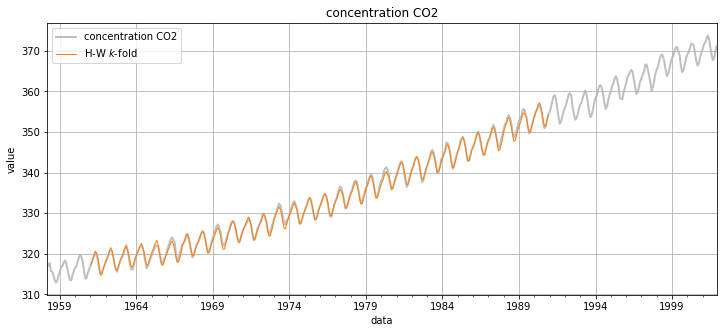

In [ ]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# plot dynamic of series and forecasts
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_exp_smooth_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                             label="H-W $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;

Count metrics on "test intervals"

In [ ]:
has_forecast = tscv_exp_smooth_forecast.isnull().any(axis=1)

exp_smooth_score_values = pd.Series({
    name: metric(dataset.loc[~has_forecast],
                 tscv_exp_smooth_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [ ]:
exp_smooth_score_values

mse    0.270927
dtype: float64

Compare with baselines on folds of training set

In [ ]:
#TODO: your code is here

# <span style="color:blue;">**Seminar 3**</span>

   
#### Seminar 3.
    
4. Building an autoregressive model and a moving average
    
    
5. Reducing the dimension of data
    1. Singular spectral decomposition
    

6. Comparison of predictive models
    

## 4. Building an autoregressive model and a moving average

Autoregressive Integrated Moving Average (ARIMA) and Seasonal Autoregressive Integrated Moving Average (SARIMA), in the second model requires the choice of hyperparameters for both trend and seasonal elements of the series..



Read here: [seasonality in autoregressive models](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

* $ \phi (\cdot) $ and $ \theta (\cdot) $ - "lag polynomials" have no common roots

* $ \phi (\cdot) $ has no unit roots

* $ \varepsilon_t $ - white noise, i.e. has zero mean, constant variance, and zero autocorrelation.

The $ ARIMAX (p, d, q) $ process with exogenous variables has the form

\begin{align}
    y_t & = \overbrace {\mu + x_t \beta} ^ {\tau_t} + \delta_t
        \ ,, \\
    (1 - L) ^ d \, \delta_t & = u_t
        \ ,, \\
    \underbrace {\Bigl (1 - \sum_ {k = 1} ^ p \phi_k L ^ k \Bigr)} _ {\phi (L)}
        \, u_t & = \mu + \underbrace {\Bigl (1 + \sum_ {k = 1} ^ q \theta_k L ^ k \Bigr)} _ {\theta (L)}
        \, \varepsilon_t
        \ ,,
\end{align}

where $ L $ is the operator of shifting back one step into the past, i.e. $ L \, y_t = y_ {t-1} $

#### Evaluation Strategy for ARIMA Models (Box-Jenkins)

1. Check the fulfillment of the assumptions about stationarity, and find transformations that bring the series to stationarity

2. Diagnose autocorrelation to determine the order of lags in AR (`pacf`) and MA (` acf`) parts. Estimate the seasonality.

3. Among the reasonable combinations of orders, choose the one whose model has the smallest criterion **BIC** or **AIC**.

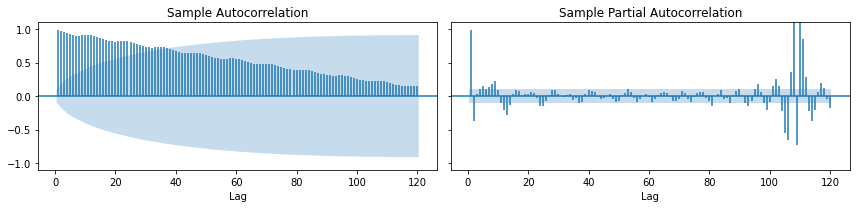

In [ ]:
correlation_diagnostics(train, lags=120) ;

* autocorrelation of small lags is close to $1.0$ and decreases rather slowly
* there are suspicious fluctuations

There seems to be a unit root $ y_t = y_ {t-1} + \ldots $.

Train model ARIMA $(0, 1, 0)$

In [ ]:
model_010 = ARIMA(train, order=(0, 1, 0))

model_010_fitted = model_010.fit(disp=0)

Let's look at its residuals on the training set (and in differences)

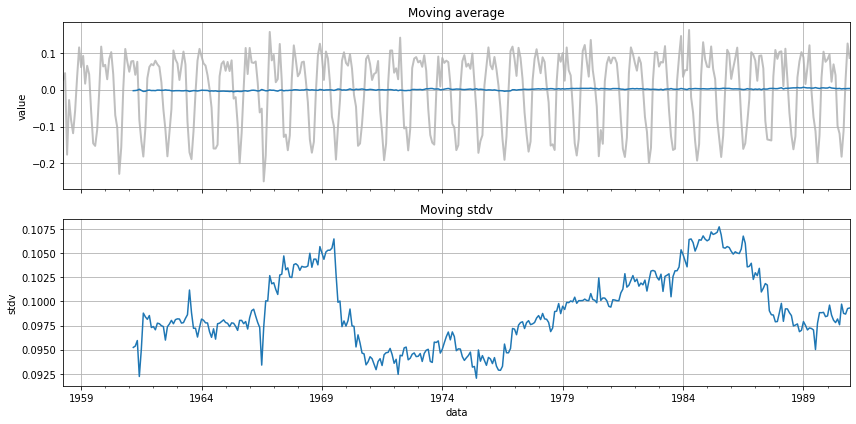

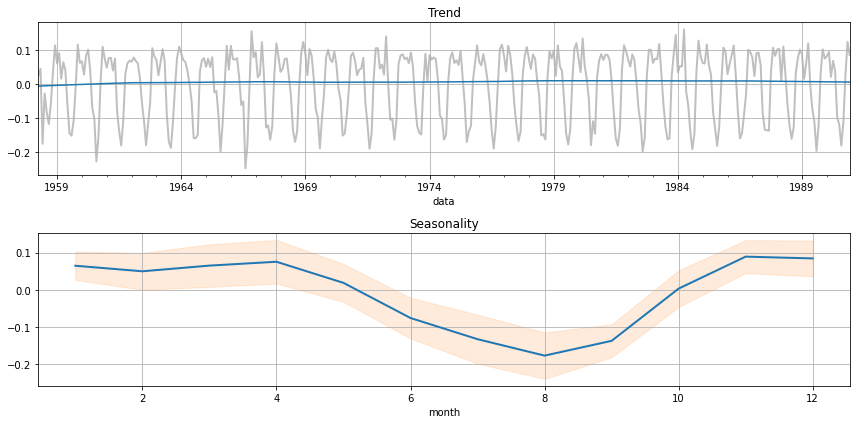

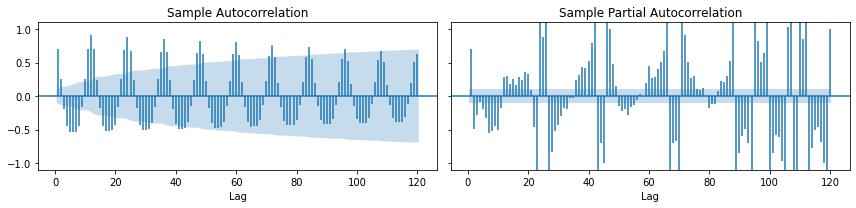

{'ADF': (-4.805363820003442, 0.00045837144209319425),
 'KPSS': (0.05248524692466159, 0.1)}

In [ ]:
diagnostics(model_010_fitted.resid, window=36, lags=120)

* A slow decrease in periodic ($ 12 $) bursts indicates a seasonal dependence of the form $ y_t = y_ {t-12} + \ldots $

The data seems to correlate with each other on a monthly basis, but also their level depends on the value of $ 12 $ months ago.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Process SARIMA$(p, d, q)\times (P, D, Q)_{s}$ has a form

\begin{align}
    (1 - L)^d \, (1 - L^s)^D \, y_t &= u_t
        \,, \\
    \Bigl(1 - \sum_{j=1}^p \phi_k L^j\Bigr)
        \, \Bigl(1 - \sum_{j=1}^P \tilde{\phi}_k L^{s j}\Bigr)
        \, u_t &= \mu \, +
        \, \Bigl(1 + \sum_{j=1}^q \theta_k L^j\Bigr)
        \, \Bigl(1 + \sum_{j=1}^Q \tilde{\theta}_k L^{s j}\Bigr)
        \, \varepsilon_t
        \,.
\end{align}

Let's look at its residuals on the training set for different orders of models

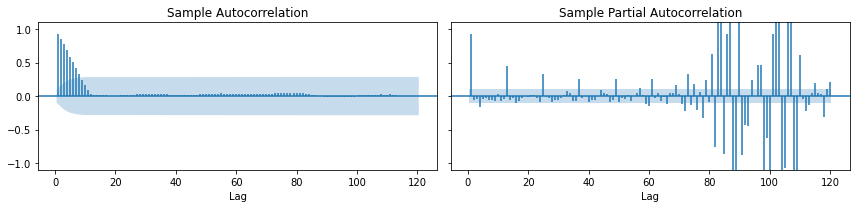

In [ ]:
model_sarima_000_010_12 = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_000_010_12_fitted = model_sarima_000_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_000_010_12_fitted.resid, lags=120) ;

* When taking the difference $ y_t - y_ {t-12} $, it seems that there are traces of the usual unit root

Let's examine the model
$$
    (1 - L^{12})(1 - L) y_t
        = \bigl[y_{t} - y_{t-1} - y_{t-12} + y_{t-13}\bigr]
        = \mu + \varepsilon_t
    \,,$$

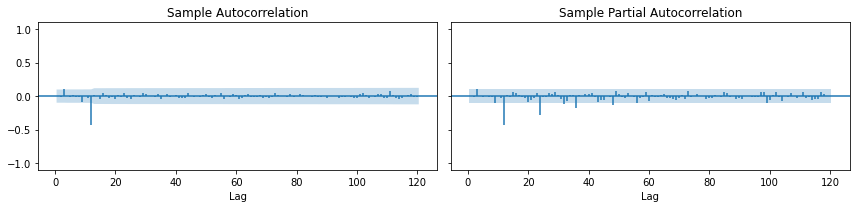

In [ ]:
model_sarima_010_010_12 = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12),

                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_010_010_12_fitted = model_sarima_010_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_010_010_12_fitted.resid, lags=120) ;

* appears to have non-zero moving average effects

Let's add a moving average to the seasonal and regular parts.

In [ ]:
#TODO: your code is here

It seems that almost all the lags have been taken into account ... Let's try to weaken the unit roots

In [ ]:
#TODO: your code is here

Return unit roots

In [ ]:
#TODO: your code is here

Judging by the sample autocorrelations, the series of residuals is very similar to the stationary
* no autocorrelations left
* no deterministic stochastic trend

Chose model with the lowest value of **BIC** (Bayesian information criterion)

Read here: [BIC](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9)

In [ ]:
models = [
  model_010_fitted,
  model_sarima_000_010_12_fitted,
  model_sarima_010_010_12_fitted,
  model_sarima_011_011_12_fitted,
  model_sarima_101_101_12_fitted,
  model_sarima_111_111_12_fitted,
  model_sarima_211_111_12_fitted,
]

[getattr(mdl, "bic") for mdl in models]

[-701.6084650084114,
 -559.8258662873832,
 -1440.9079852575487,
 -1623.8069925449977,
 -1563.5248671519707,
 -1643.0280832790095,
 -1636.5214504295086]

In [ ]:
sarima_fitted = models[5]

The `SARIMAX` object returns the fitted values ​​on the training sample in the` fittedvalues` property:
* the row matches the prediction in the original data values ​​(** NOT ** in the differences, like `ARIMA`)

In [ ]:
if isinstance(sarima_fitted.model, SARIMAX):
    series_fitted = sarima_fitted.fittedvalues.to_frame()

elif isinstance(sarima_fitted.model, ARIMA):
    series_fitted = np.concat([
        train.iloc[:1],             # adding a little bit of backstory (for integral)
        sarima_fitted.fittedvalues,  # fitted values added
    ], axis=0).cumsum(axis=0)

Inverse transformation

In [ ]:
series_fitted = transformer.inverse_transform(series_fitted)

fitted_arima = pd.Series(series_fitted.ravel(),
                         name=target_column,
                         index=dataset.index)

Let's look on plot of fitting

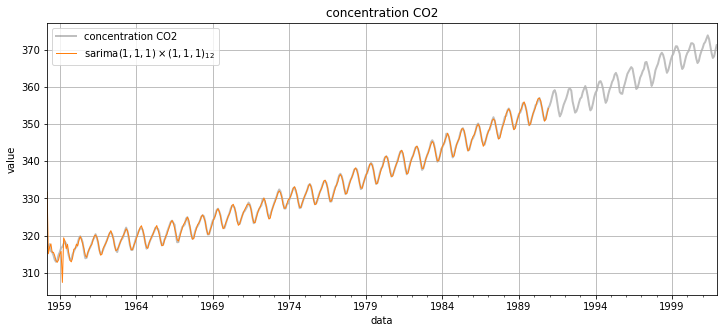

In [ ]:
# create and set a plit
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plot dynamic of series
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

fitted_arima.plot(ax=ax, color="C1", lw=1, alpha=1.0,
                  label="sarima$(1,1,1)\\times(1,1,1)_{12}$")

ax.grid(which="major", axis="both")
ax.legend() ;


Let's look at the **dynamic** forecast for $ 240 $ months ahead

In [ ]:
# Forecast for 240 month forward
sarima_forecast = sarima_fitted.forecast(steps=240).to_frame()

sarima_forecast = pd.DataFrame(transformer.inverse_transform(sarima_forecast),
                            columns=sarima_forecast.columns,
                            index=sarima_forecast.index)

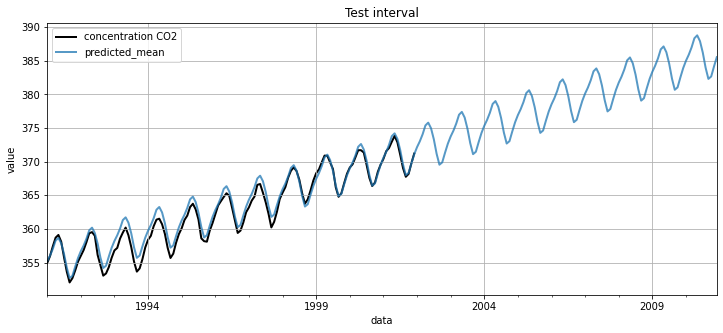

In [ ]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title="Test interval")

# plot dynamic
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

sarima_forecast.plot(ax=ax, color="C0", lw=2, alpha=0.75, label="dynamic forecast sarima")

ax.grid(which="major", axis="both")
ax.legend() ;

Count metrics

In [ ]:
holdout_sarima_score_values = pd.Series({
    name: metric(holdout[target_column],
                 sarima_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [ ]:
holdout_sarima_score_values

mse    0.974017
dtype: float64

Validation of model

In [ ]:
raw_forecast = np.full_like(dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split on train and test
    cv_train = safe_indexing(dataset, train_ix)

    # 1. "forward transformation" of series
    cv_transformer = clone(transformer).fit(cv_train)
    cv_train = pd.DataFrame(cv_transformer.transform(cv_train),
                            index=cv_train.index, columns=cv_train.columns)

    # 2. model estimation
    cv_model = SARIMAX(cv_train[target_column],
                       order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

    try:
        cv_model_fitted = cv_model.fit(disp=0)
    except ValueError:
        continue

    # 3. building forecast
    cv_test = safe_indexing(dataset, test_ix)
    cv_forecast = cv_model_fitted.forecast(len(cv_test)).to_frame()

    # 4. "inverse transformation" of raw
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_forecast)

20it [00:22,  1.13s/it]


Unfortunately, due to the modesty of the sample size, sometimes SARIMA is estimated inadequately (on series with a short history).

In [ ]:
raw_forecast[np.nan_to_num(raw_forecast) <= 0] = np.nan

raw_forecast[~np.isfinite(raw_forecast)] = np.nan

tscv_sarima_forecast = pd.DataFrame(raw_forecast, index=dataset.index, columns=dataset.columns)

Collecting forecasts in series and plotting

In [ ]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plot dynamic of series and forecasts
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_sarima_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                         label="sarima $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;


Counting metric on "test intervals"

In [ ]:
has_forecast = tscv_sarima_forecast.isnull().any(axis=1)

sarima_score_values = pd.DataFrame.from_dict({
    name: metric(dataset.loc[~has_forecast],
                 tscv_sarima_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [ ]:
sarima_score_values

## 5. Dimensionality reduction*

#### A. Singular Spectral Decomposition

This method is based on dimensionality reduction of a special time series representation

+ **+** works naturally with multidimensional data
+ **-** you need to explicitly set the number of hidden factors
+ **-** highlighted latent factors need to be modeled separately

In [ ]:
n_embedding, n_components = 12, 4

n_samples, n_targets = dataset.shape

For this method, you need to be able to "pack" the rows in a "snake"

* Forward transformation for building matrix $Y_t$ on base of series $(y_s)_{s=1}^t$:

\begin{equation}
    y_1,\,,\ldots,\,y_{t-1},\,y_t
    \quad \mapsto
    \quad Y_t =
        \begin{pmatrix}
            y_1                 & \color{orange}{y_2} & \color{red}{y_3}  & \cdots & y_p     \\
            \color{orange}{y_2} & \color{red}{y_3}    & \color{blue}{y_4} & \cdots & y_{p+1} \\
            \color{red}{y_3}    & \color{blue}{y_4}   & y_5               & \cdots & y_{p+2} \\
            \vdots              & \vdots              & \vdots            & \ddots & \vdots  \\
            y_{t-p+1}           & y_{t-p+2}           & y_{t-p+3}         & \cdots & y_t     
        \end{pmatrix}
\end{equation}

In [ ]:
def embed_transform(X, n_embedding):
    # Lags from n_lags - 1 to 1
    n_lags = n_embedding - 1
    lagged = [X[k:k - n_lags] for k in range(n_lags)]

    # current value

    lagged.append(X[n_lags:])

    # join and return
    embed = np.stack(lagged, axis=1)
    return embed.reshape(len(X) - n_lags, -1)

* Inverse transformation: calculate the average over all anti-diagonals of the matrix $ X_t $

* Anti-diagonals in the * bottom right * corner may be "incomplete"

\begin{equation}
    X_t
    = \begin{pmatrix}
        x^1_p         & \color{orange}{x^{(2)}_p}     & \color{red}{x^{(3)}_p}     & \cdots & x^{(p)}_p     \\
        \color{orange}{x^{(1)}_{p+1}} & \color{red}{x^{(2)}_{p+1}} & \color{blue}{x^{(3)}_{p+1}} & \cdots & x^{(p)}_{p+1} \\
        \color{red}{x^{(1)}_{p+2}} & \color{blue}{x^{(2)}_{p+2}} & x^{(3)}_{p+2} & \cdots & x^{(p)}_{p+2} \\
        \vdots        & \vdots        & \vdots        & \ddots & \vdots        \\
        x^{(1)}_t     & x^{(2)}_t     & x^{(3)}_t     & \cdots & x^{(p)}_t
    \end{pmatrix}
    \quad \mapsto
    \quad \tfrac1{p} \sum_{j=0}^{p-1} \color{red}{x^{(p-j)}_{s+j}}
    \,, s=p,\,\ldots,\,t
\end{equation}

In [ ]:
def embed_inverse_transform(X, n_targets):
    assert (X.shape[1] % n_targets) == 0

    result = np.zeros((len(X), n_targets), dtype=float)
    for k in range(n_targets):
        # choosing data of k's feature
        X_k = X[:, k::n_targets]
        n_embedding = X_k.shape[1]

        # We calculate the average over all anti-diagonals (even incomplete ones!)
        result[:, k] = np.array([
            np.diag(X_k[j:j + n_embedding, ::-1]).mean()
            for j in range(len(X))
        ])
    return result

1) A direct transformation creates a matrix $𝑌_𝑡$ from the series $𝑦_𝑡$

In [ ]:
data_Y = embed_transform(train, n_embedding)

# np.round(data_Y[:4], 2)  #  making sure of right structure

# np.allclose(embed_inverse_transform(data_Y, n_targets), train.values[n_embedding-1:, -1:])

2) Highlighted $ m <p $ hidden factors $f_s = (f^{(1)}_s,\,\ldots,\,f^{(m)}_s)$

\begin{equation}
    F_t
    = \begin{pmatrix}
        f^{(1)}_p        & \cdots & f^{(m)}_p      \\
        f^{(1)}_{p+1}    & \cdots & f^{(m)}_{p+1}  \\
        \vdots           & \ddots & \vdots         \\
        f^{(1)}_t        & \cdots & f^{(m)}_t
    \end{pmatrix}
\end{equation}

  * the ** PCA ** method looks for a $ m $ -dimensional linear transformation of data into factors:

    - low approximation error: $ y_ {s + j} \ approx \ sum_ {k = 1} ^ m f ^ {(k)} _ s v_ {kj} $
    for all where $ s = 1 \ ,, \ ldots \ ,, t-p + 1 $ and $ j = 0, \, \ ldots, \, p-1 $

    - transformation components are linearly independent and pairwise perpendicular

In [ ]:
from sklearn.decomposition import PCA

ssa = PCA(n_components=n_components)

data_F = pd.DataFrame(ssa.fit_transform(data_Y), index=dataset.index[n_embedding - 1:])

A typical situation for methods based on the calculation of eigenvectors:
* components are highlighted, ordered by frequency

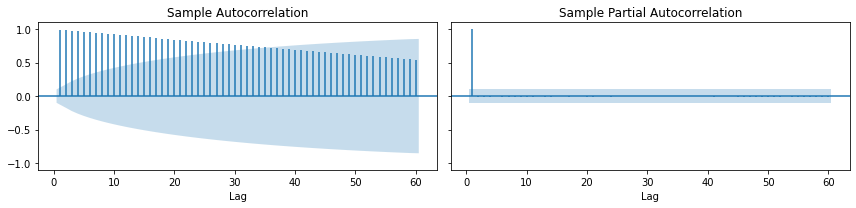

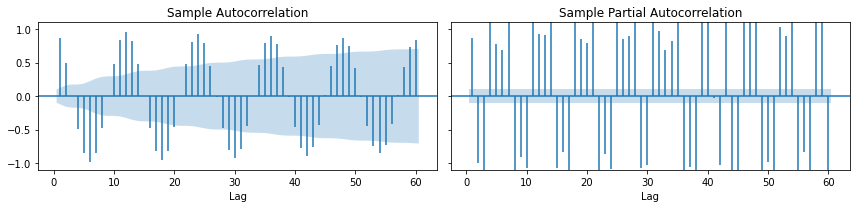

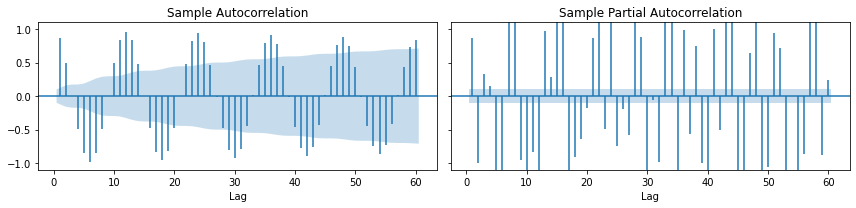

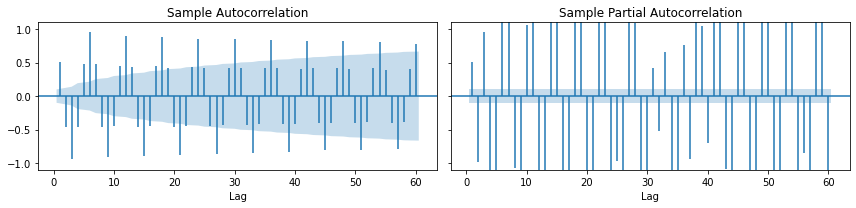

In [ ]:
for j in range(ssa.n_components_):
    correlation_diagnostics(data_F[j]) ;

Let's perform the inverse transformation of the factors on the training sample

In [ ]:
data_fitted = ssa.inverse_transform(data_F)

ssa_fitted = embed_inverse_transform(data_fitted, n_targets)

ssa_fitted = pd.DataFrame(ssa_fitted, index=data_F.index, columns=dataset.columns)

Looking on residuals

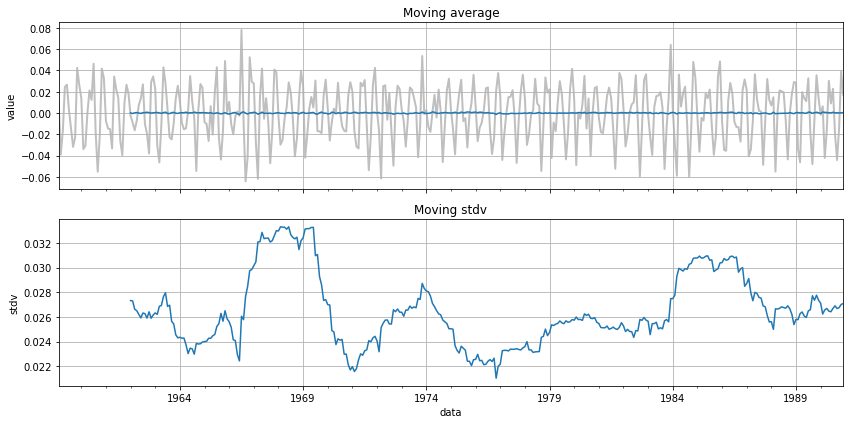

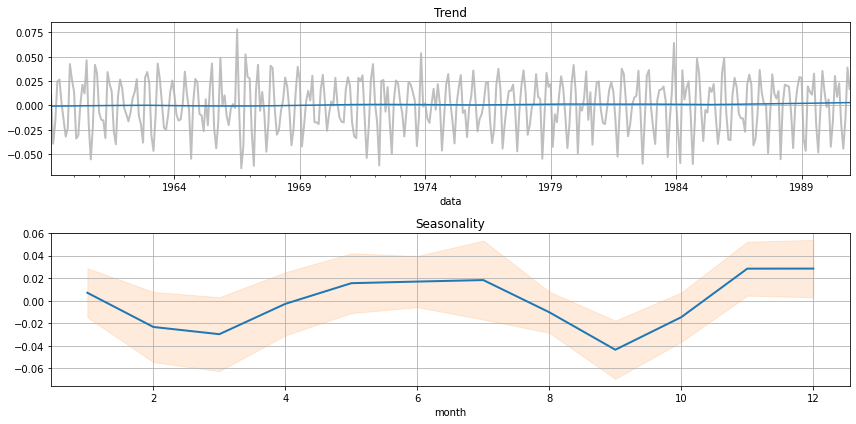

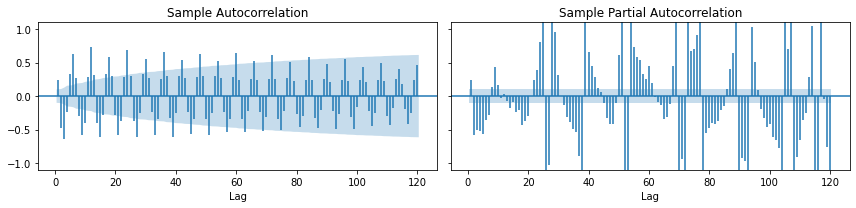

{'ADF': (-8.259302392815217, 1.7983799853009723e-11),
 'KPSS': (0.08329462599827403, 0.1)}

In [ ]:
ssa_residuals = train[target_column].iloc[-len(ssa_fitted):] - ssa_fitted[target_column]

diagnostics(ssa_residuals, window=36, lags=120)

3) The time series model is trained on the $ j $ -th hidden factor series $ f ^ {(j)} _ s $ where $ s = p, \, p + 1, \, \ldots, \, t $
* we will use the Holt-Winters method

In [ ]:
models = []
for j in range(ssa.n_components_):
    exp_mod = ExponentialSmoothing(data_F[j], trend="add", seasonal="add",
                                   seasonal_periods=12)
    models.append(exp_mod.fit(remove_bias=True))

4) Let's make a forecast for 240 month

In [ ]:
n_horizon = 240

latent_pred = pd.concat([
    mdl.forecast(n_horizon) for mdl in models
], axis=1)

Looking how forecasts look

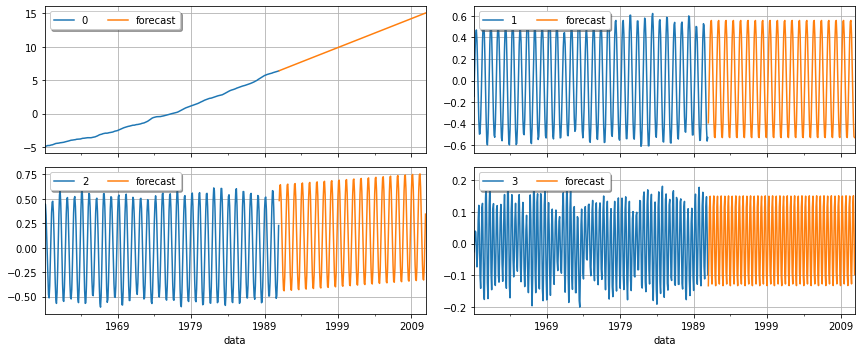

In [ ]:
# create and set a plot
fig = plt.figure(figsize=(12, 5))
axes = fig.subplots(nrows=2, ncols=2, sharex=True)

for (col, ser), ax in zip(data_F.items(), axes.ravel()):
# plot dynamics of hidden factors
    ser.plot(ax=ax, color="C0")
    latent_pred[col].plot(ax=ax, color="C1", label="forecast")

    ax.grid(which="major", axis="both")
    ax.legend(loc="upper left", ncol=2, shadow=True)

fig.tight_layout() ;

Building forecasts of original series

In [ ]:
ssa_forecast = ssa.inverse_transform(latent_pred)

# inverse transformation
ssa_forecast = embed_inverse_transform(ssa_forecast, n_targets)

ssa_forecast = transformer.inverse_transform(ssa_forecast)

ssa_forecast = pd.DataFrame(ssa_forecast, index=latent_pred.index,
                            columns=["forecast "+ col for col in dataset.columns])

Plotting it

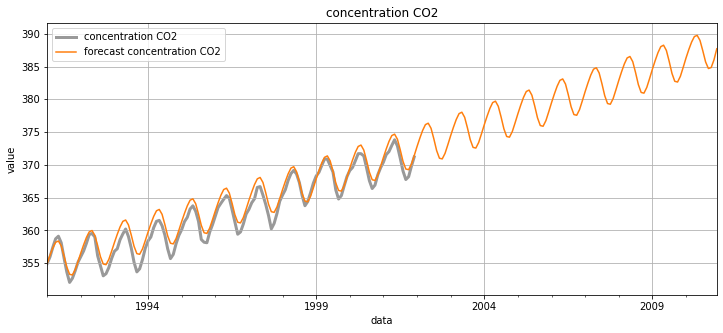

In [ ]:
# create and set a plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plot dynamic of whole series
holdout[target_column].plot(ax=ax, color="black", lw=3, alpha=.4, zorder=-10)

ssa_forecast.plot(ax=ax, color="C1", lw=1.5)

ax.grid(which="major", axis="both")
ax.legend() ;


Counting metrics

In [ ]:
holdout_ssa_score_values = pd.Series({
    name: metric(holdout[target_column],
                 ssa_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [ ]:
holdout_ssa_score_values

mse    1.56145
dtype: float64

Validation of model

In [ ]:
raw_forecast = np.full_like(dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split on train and tes
    cv_train = safe_indexing(dataset, train_ix)
    cv_train_index = cv_train.index

    # 1. "forward transform" of series
    cv_transformer = clone(transformer)
    cv_train = cv_transformer.fit_transform(cv_train)

    # 2.1 estimation of model: highliting of factors
    cv_embed_train = embed_transform(cv_train, n_embedding)

    cv_ssa_model = clone(ssa)
    cv_factors = cv_ssa_model.fit_transform(cv_embed_train)

    cv_factors = pd.DataFrame(cv_factors, index=cv_train_index[n_embedding - 1:])

    # 2.2  model estimation
    try:
        cv_models = []
        for j in range(cv_ssa_model.n_components_):
            cv_exp_mod = ExponentialSmoothing(cv_factors[j],
                                              trend="add", seasonal="add",
                                              seasonal_periods=12)

            cv_models.append(cv_exp_mod.fit(remove_bias=True))
    except ValueError:
        continue

    # 3.1 builing forecast : factors
    cv_test = safe_indexing(dataset, test_ix)

    cv_factors_pred = pd.concat([
        mdl.forecast(len(cv_test)) for mdl in cv_models
    ], axis=1)

    # 3.2 forecasting: inverse nesting and anti-diagonal averaging
    cv_ssa_forecast = cv_ssa_model.inverse_transform(cv_factors_pred)

    cv_ssa_forecast = embed_inverse_transform(cv_ssa_forecast, n_targets)

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_ssa_forecast)

tscv_ssa_forecast = pd.DataFrame(raw_forecast, index=dataset.index, columns=dataset.columns)

20it [00:16,  1.22it/s]


Collecting forecasts in series and plotting

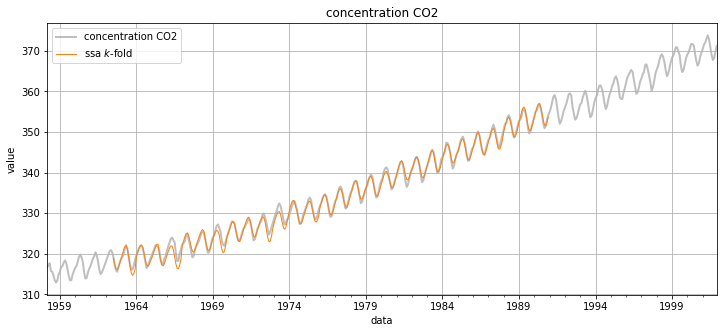

In [ ]:
# create and set a plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plot dynamic of series and forecasts
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_ssa_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                      label="ssa $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;


Counting metrics on "test intervals"

In [ ]:
has_forecast = tscv_ssa_forecast.isnull().any(axis=1)

ssa_score_values = pd.Series({
    name: metric(dataset.loc[~has_forecast],
                 tscv_ssa_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [ ]:
ssa_score_values

## 6. Models comparison

Summary table of metrics on holdout/cross-validation

In [ ]:
# TODO: which model are best on holdout and cross-valiadtion?
